# Basic Implicit Rendering

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [3]:
from kaigeo import datasets, nerf_models

In [4]:
device = torch.device('cuda')

In [5]:
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    look_at_view_transform,
    RayBundle,
    ray_bundle_to_ray_points,
    NDCGridRaysampler,
    EmissionAbsorptionRaymarcher,
    AbsorptionOnlyRaymarcher,
    ImplicitRenderer
)

In [6]:
# render_size describes the size of both sides of the 
# rendered images in pixels. Since an advantage of 
# Neural Radiance Fields are high quality renders
# with a significant amount of details, we render
# the implicit function at double the size of 
# target images.
render_size = 128
# Our rendered scene is centered around (0,0,0) 
# and is enclosed inside a bounding box
# whose side is roughly equal to 3.0 (world units).
volume_extent_world = 20.0

raysampler_grid = NDCGridRaysampler(
    image_height=render_size,
    image_width=render_size,
    n_pts_per_ray=20,
    min_depth=0.1,
    max_depth=volume_extent_world,
)

raymarcher = EmissionAbsorptionRaymarcher() #AbsorptionOnlyRaymarcher()#AbsorptionRaymarcher()

renderer_grid = ImplicitRenderer(
    raysampler=raysampler_grid, raymarcher=raymarcher,
)

/home/brett/miniconda3/envs/geometry/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811803361/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
color = torch.rand((3,), requires_grad=True, device=device)

In [8]:
opt = torch.optim.Adam([color], lr=0.1)

In [198]:
class OurModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.thing = nn.Sequential(
            nn.Linear(3, 20),
            nn.Sigmoid(),
            nn.Linear(20, 40),
            nn.Sigmoid(),
            nn.Linear(40, 40),
            nn.Sigmoid(),
            nn.Linear(40, 3),
            nn.Sigmoid()
        )
        
    def forward(self, X):        
        out = self.thing(X.view(-1, 3))
        
        return out.reshape(X.shape)
        

In [199]:
om = OurModel().to(device)

In [200]:
opt = torch.optim.Adam(om.parameters(), lr=0.1)

In [201]:
def volumetric_function_hard(
    ray_bundle: RayBundle,
    **kwargs):

    rays_points_world = ray_bundle_to_ray_points(ray_bundle)       
    rays_densities = torch.where(
        rays_points_world.norm(keepdim=True, dim=-1) > 0.05, 0.0, 1.0)
    
    c = om(rays_points_world)#torch.randn_like(rays_points_world) * 20.0 + color

    return rays_densities, c

In [202]:
R, T = look_at_view_transform(
    eye=torch.tensor([[0.1, 0.0, 0.0]]), 
    at = torch.tensor([[0.0, 0.0, 0.0]])
)

target_cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

In [203]:
from kaigeo import datasets

In [204]:
session = datasets.load_session1()

In [ ]:
sesoin

In [205]:
target = session.target_images[1].to(device)

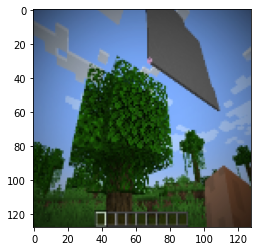

In [302]:
plt.imshow(session.target_images[3].detach().cpu().numpy())

In [304]:
session.forward

array([[ 0.4506194 ,  0.51796252, -0.72704482],
       [ 0.46096972,  0.48403051, -0.74374437],
       [ 0.46096972,  0.48403051, -0.74374437],
       [ 0.46096972,  0.48403051, -0.74374437],
       [ 0.46096972,  0.48403051, -0.74374437],
       [ 0.37592208,  0.3214092 , -0.86908925],
       [-0.1462483 ,  0.01045005, -0.98919272],
       [-0.24632674,  0.        , -0.96918684],
       [-0.24632674,  0.        , -0.96918684],
       [-0.24632674,  0.        , -0.96918684],
       [-0.24632674,  0.        , -0.96918684],
       [-0.24632674,  0.        , -0.96918684],
       [-0.24632674,  0.        , -0.96918684],
       [-0.24632674,  0.        , -0.96918684],
       [-0.24632674,  0.        , -0.96918684],
       [-0.70346552, -0.01045005, -0.71065116],
       [-0.9943682 , -0.08360014, -0.06501476],
       [-0.9943682 , -0.08360014, -0.06501476],
       [-0.9943682 , -0.08360014, -0.06501476],
       [-0.9943682 , -0.08360014, -0.06501476],
       [-0.9943682 , -0.08360014, -0.065

In [207]:
res, _ = renderer_grid(target_cameras, volumetric_function_hard)

In [211]:
#target = torch.tensor([1.0, 0.0, 0.0], device=device)

# try to make it/ as red as possible
for i in range(10000):
    opt.zero_grad()
    res, _ = renderer_grid(target_cameras, volumetric_function_hard)
    img = res[:, :, :, 0:3]
    dist = torch.nn.functional.l1_loss(img[0], target)
    dist.backward()
    opt.step()

KeyboardInterrupt: 

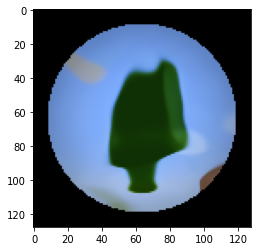

In [212]:
plt.imshow(img[0].detach().cpu().numpy())

In [215]:
om.thing

Sequential(
  (0): Linear(in_features=3, out_features=20, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=20, out_features=40, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=40, out_features=40, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=40, out_features=3, bias=True)
  (7): Sigmoid()
)

In [305]:
def plot_camera(eye, at):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection="3d")
    ax.view_init(vertical_axis="y")

    ax.plot(eye[:, 0], eye[:, 1], eye[:, 2])
    ax.quiver3D(
        eye[:, 0], eye[:, 1], eye[:, 2], at[:, 0], at[:, 1], at[:, 2], color="r"
    )

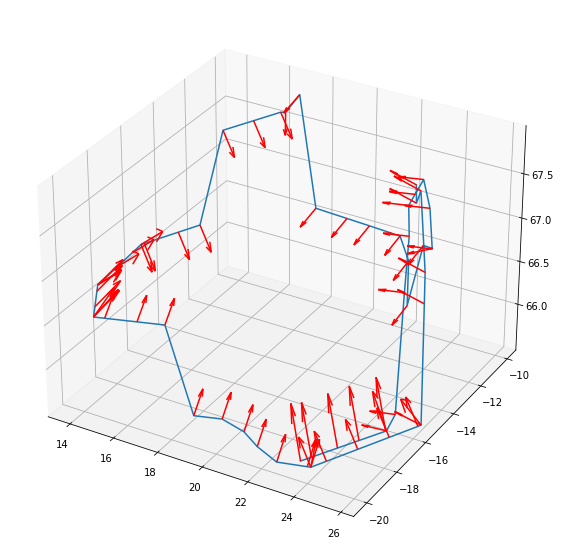

In [307]:
plot_camera(session.eye, session.look)

In [293]:
r = torch.rand(1000000, 3) * 100.0
x = torch.cos(r[:, 0])
y = torch.sin(r[:, 1])
z = torch.sqrt(1.0 - x**2.0 - y**2.0)

indices = torch.randint(len(z) // 2, size=(1, len(z) // 2))
z[indices] = -z[indices]

In [294]:
xyz = torch.stack([x, y, z], axis=1).to(device)

In [295]:
c = om.thing(xyz)

In [296]:
from matplotlib import pyplot as  plt

In [297]:
xyz = xyz.detach().cpu().numpy()
c = c.detach().cpu().numpy()

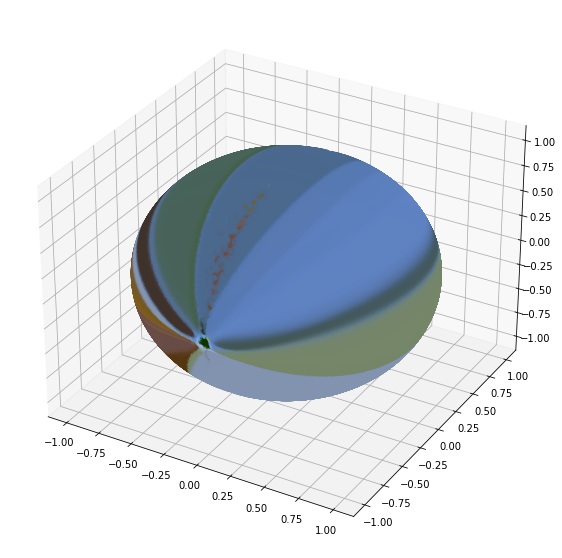

In [298]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
ax.view_init(vertical_axis="y")
ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], alpha=0.5, c=c)

In [299]:
import open3d as o3d

# generate some neat n times 3 matrix using a variant of sync function

#important = m.get_meaningful_points(True)
#xyz = m.geometry_model.pos[important].detach().cpu().numpy()
#colors = torch.sigmoid(m.geometry_model.col[important]).detach().cpu().numpy()

# Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
pcd = o3d.geometry.PointCloud()

pcd.points = o3d.utility.Vector3dVector(xyz)
pcd.colors = o3d.utility.Vector3dVector(c)
o3d.visualization.draw_geometries([pcd])
